# Analyzing the Capacity of SOMs to clear outliers

In this notebook, we're going to analyze how SOms can identify outliers in the dataset and then, reduce the rate of the false alarms.

In [34]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from modules.som_detector import SOM_outlier_detector
from modules.anomaly_detector import AnomalyDetectionKit

# ignore warnings
warnings.filterwarnings('ignore')

In [35]:
# load data
x = pd.read_csv('../0_data/som_studies/normal_operation_compressor.csv',
                index_col=[0])
x.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-506D-X,XT-506D-Y,XT-507D-X,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,13.370263,11.907991,8.478170,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,13.718800,12.062502,8.429724,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,13.031363,11.878652,8.444281,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,13.584080,12.130912,8.444281,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,13.545857,12.169901,8.458838,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740


In [36]:
# apply classical anomaly detection (simple PCA)
adk = AnomalyDetectionKit()

# do parallel analysis
adk.parallel_analysis(x)

Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %


In [37]:
# fit the final PCA
adk.fit_final(x)

# calculate T2s and SPEs
t2s, tmax = adk.calculate_T2(data=x)
spe, spe_max = adk.calculate_SPE(data=x)

# create analysis dataframe
data = x.copy()
data['t2'] = t2s
data['spe'] = spe

# calculate baseline metrics
adk.calculate_metrics(data_stats=data[['t2', 'spe']], limits=[tmax, spe_max])

(0.08635996771589992, 0.1560398170567662, 0.026903416733925208)

Now, after applying the first PCA, let's use the SOM to detect outliers. In this case, SOM will use the statistics T2 and SPE as inputs.

In [38]:
# create and fit som
som = SOM_outlier_detector()
som.fit_som(x=data[['t2', 'spe']], n=2)

In [39]:
# calculate distances
data['dist'] = som.average_distances(data[['t2', 'spe']])
data.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D,t2,spe,dist
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259,15.304634,5.927580,0.622132
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747,15.945228,6.908700,0.622132
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333,18.024413,5.310536,0.622132
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624,20.725690,4.206950,1.000000
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740,19.876844,3.748764,1.000000


Apparently, each time SOMs are runned, they return a different result of average distance. This is because their initialization are random. We need to simulate many times and understand if there is some type of distance stabilization.

This is necessary because if we rely on a single run, we may eliminate values that are not outliers, simply because they might had the bad luck to be assigned to a different neuron.

In [69]:
N = 200
dists = []
for i in range(N):
    
    # fit som
    som.fit_som(x=data[['t2', 'spe']], n=2)

    # calculate distances
    dists.append(som.average_distances(data[['t2', 'spe']]).values)

all_dists = np.concatenate(dists, axis=1)

<Axes: >

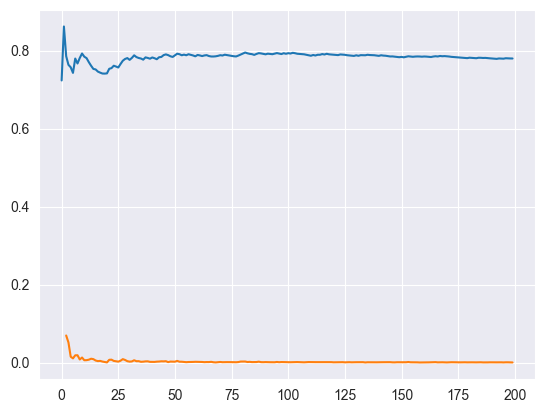

In [70]:
sample_df = pd.DataFrame(all_dists[0], columns=['Sample_0'])
sample_df[['cum_mean']] = sample_df['Sample_0'].expanding().agg(func={np.mean})
sample_df['variation'] = sample_df['cum_mean'].rolling(3).std()

sample_df['cum_mean'].plot()
sample_df['variation'].plot()